# <center>DataLab Cup 2: CNN for Object Detection<center/>

# Data provided
## Dataset: PASCAL VOC2007

In [1]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

# Processed data format

The data format of pascal_voc_training_data is:\
[ $image\_name$, $xmin_i$, $ymin_i$, $xmax_i$, $ymax_i$, $class_i$ ]

In [2]:
training_data_file = open("Dataset/2023-datalab-cup2-object-detection/pascal_voc_training_data.txt", "r")
for i, line in enumerate(training_data_file):
    if i >5:
        break
    line = line.strip()
    print(line)

000005.jpg 263 211 324 339 8 165 264 253 372 8 5 244 67 374 8 241 194 295 299 8 277 186 312 220 8
000007.jpg 141 50 500 330 6
000009.jpg 69 172 270 330 12 150 141 229 284 14 285 201 327 331 14 258 198 297 329 14
000012.jpg 156 97 351 270 6
000016.jpg 92 72 305 473 1
000017.jpg 185 62 279 199 14 90 78 403 336 12



正如您所看到的，一張圖像可能包含多個物體。另一個需要注意的是，該數據集中圖像的高度和寬度是不同的。因此，建議您將圖像和地面真實邊界框的坐標重新調整為相同的大小。

在這個競賽中，您可以實現各種物體檢測模型（如 R-CNN、Fast-RCNN、Faster-RCNN、YOLOs、SSD 等）。這裡我們提供了一個基於 YOLO（You Only Look Once）的簡單模板。

In [3]:
import tensorflow as tf
import numpy as np

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


- #### Hyperparameters

In [5]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 8
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
DATA_PATH = "Dataset/2023-datalab-cup2-object-detection/pascal_voc_training_data.txt"
IMAGE_DIR = "Dataset/2023-datalab-cup2-object-detection/VOCdevkit_train/VOC2007/JPGEImages/"

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-4
EPOCHS = 3

我們將定義一個類別來處理訓練資料，讀取來自 "pascal_voc_training_data.txt" 的記錄，並按照以下步驟準備數據供我們的網絡使用：

使用 TensorFlow 數據 API 創建數據集。
在數據集的 map 函數中，讀取圖像並進行預處理（例如，調整大小，歸一化）。
在數據集的 map 函數中，將框的信息 [xmin、ymin、xmax、ymax] 座標更改為 [xcenter、ycenter、width、height] 屬性，這對 YOLO 模型更容易使用。
進行批處理（Batch）和洗牌（Shuffle）操作。

In [6]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(DATA_PATH, "r")

        for line in input_file:
            line = line.strip()
            ss = line.split(" ")
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(
                min(len(self.record_list[-1]) // 5, MAX_OBJECTS_PER_IMAGE)
            )

            # padding 使每張圖片的標註一樣長
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE * 5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] + [
                    0.0,
                    0.0,
                    0.0,
                    0.0,
                    0.0,
                ] * (MAX_OBJECTS_PER_IMAGE - len(self.record_list[-1]) // 5)

            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE * 5:
                # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][: MAX_OBJECTS_PER_IMAGE * 5]

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR + image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        # 做 normalization
        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32)
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32)

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = (image / 255) * 2 - 1

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stacktf.stack(
            [xcenter, ycenter, box_w, box_h, class_num], axis=1
        )  # 疊出的形狀是 (n, 5)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices(
            (
                self.image_names,
                np.array(self.record_list),
                np.array(self.object_num_list),
            )
        )
        dataset = dataset.shuffle(100000)
        dataset = dataset.map(
            self._data_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE
        )
        dataset = dataset.batch(BATCH_SIZE)
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

        return dataset


現在，我們可以簡單地創建一個 DatasetGenerator，該生成器可以為我們的模型提供訓練數據的批次。

# Object Detection Model (YOLO)

不同於基於區域建議的模型，YOLO將一幅圖像分成cell_size×cell_size（例如7×7）的單元格，每個單元格具有固定數量的輸出預測框（包括座標、類別編號和置信度分數）。最終的預測結果將是具有最高置信度分數的框。YOLO的預測是基於卷積層在輸入圖像上提取的特徵，實際上對每個圖像進行了一次全覽。

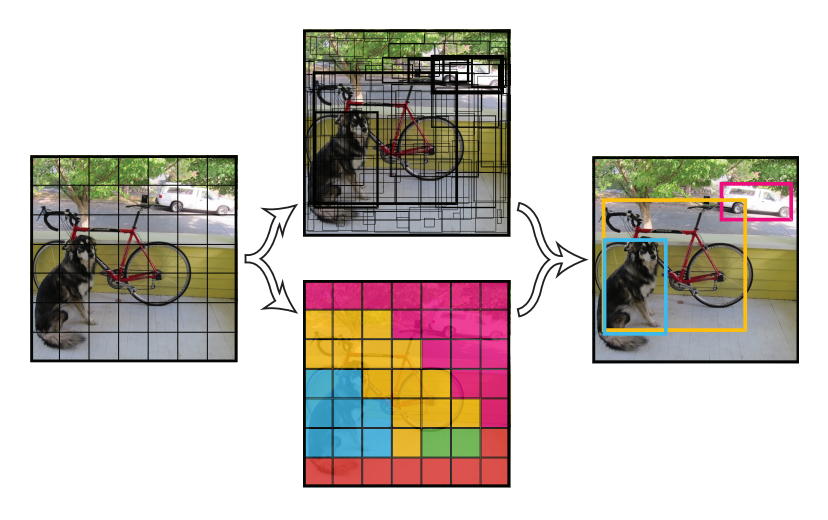

# Intersection Over Union(IoU)

YOLO的損失計算包括計算預測框和實際框之間的交集區域除以聯集區域（Intersection over Union，IoU）。IoU是評估預測框座標是否足夠精確的常見方法。IoU的計算方式如下：

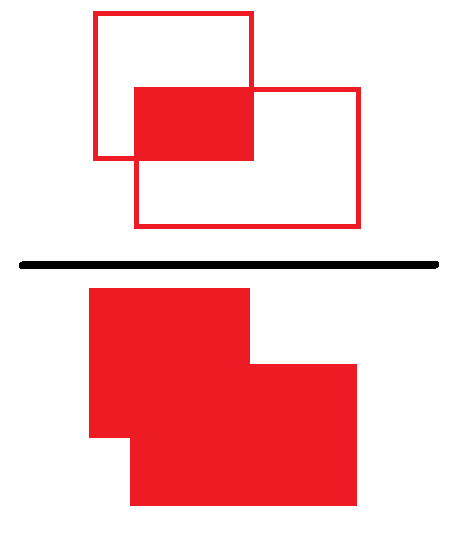

因此，我們希望預測和實際的IoU越大越好。此外，在評估物體檢測模型的優劣時，也使用IoU：如果預測框和實際框的IoU大於一個閾值，則認為預測成功。

# Model Architecture


24個卷積層後接2個全連接層。
最後一層使用線性激活函數，而所有其他層使用以下的Leaky Rectified Linear Activation：

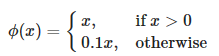

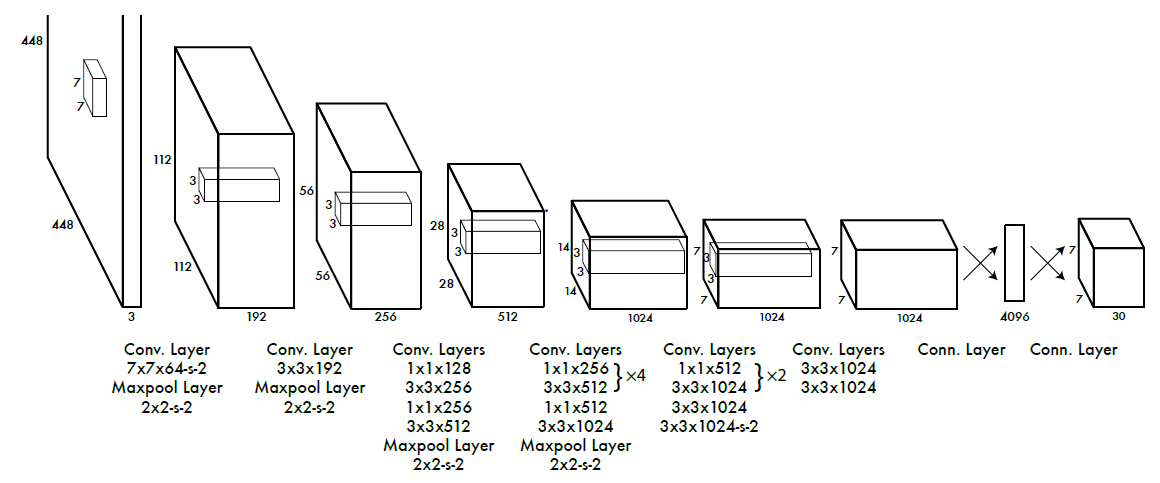

## model

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

In [8]:
def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same",
                      kernel_initializer=tf.keras.initializers.TruncatedNormal())(inputs)
    x = layers.LeakyReLU(0.1)(x)

    return x

In [9]:
img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = conv_leaky_relu(img_inputs, 64, 7, 2)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 192, 3, 1)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 128, 1, 1)
x = conv_leaky_relu(x, 256, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 512, 1, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 512, 1, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 512, 1, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 2)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = layers.Flatten()(x)
x = layers.Dense(
    4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01)
)(x)
x = layers.LeakyReLU(0.1)(x)
outputs = layers.Dense(
    1470, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01)
)(x)

YOLO = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO")

## Define loss

In [10]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x, 
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])